In [1]:
import numpy as np
from scipy.linalg import eigh_tridiagonal

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsmath}',
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']
})

import sympy as sp
from scipy.optimize import bisect

In [2]:
def get_H(x0,x1,n,V):
    x = np.linspace(x0,x1,n)
    h = x[1] - x[0]
    
    T_ = -(np.diag(np.full(n-3,1),k=-1) + np.diag(np.full(n-2,-2),k=0) + np.diag(np.full(n-3,1),k=1))/h**2
    V_ = np.diag(V(x[1:-1]))
    H  = T_ + V_
    
    return x,H

In [3]:
def solve_SE(x0,x1,n,V):
    x = np.linspace(x0,x1,n)
    h = x[1] - x[0]
    
    d = -0.5/h**2*np.full(n-2,-2) + V(x[1:-1])
    e = -0.5/h**2*np.full(n-3,1)
    
    E,psi = eigh_tridiagonal(d,e)
    psi   = np.vstack(([np.zeros(E.shape[0]),psi,np.zeros(E.shape[0])]))
    return x,E,psi.T

# Finite square well

### analytic stuff

In [47]:
A,B,C,D      = sp.symbols(r'A B C D')
k,kappa,V0,a = sp.symbols(r'k \kappa V_0 a',real=True,positive=True)
u            = sp.Symbol(r'u')

psi1 = A*sp.exp(kappa*u)
psi2 = B*sp.cos(k*u) + C*sp.sin(k*u)
psi3 = D*sp.exp(-kappa*u)

BC1 = sp.Eq(psi1.subs(u,-1)        ,psi2.subs(u,-1))
BC2 = sp.Eq(psi1.diff(u).subs(u,-1),psi2.diff(u).subs(u,-1))
BC3 = sp.Eq(psi2.subs(u,1)         ,psi3.subs(u,1))
BC4 = sp.Eq(psi2.diff(u).subs(u,1) ,psi3.diff(u).subs(u,1))

display(BC1)
display(BC2)
display(BC3)
display(BC4)

Eq(A*exp(-\kappa), B*cos(k) - C*sin(k))

Eq(A*\kappa*exp(-\kappa), B*k*sin(k) + C*k*cos(k))

Eq(B*cos(k) + C*sin(k), D*exp(-\kappa))

Eq(-B*k*sin(k) + C*k*cos(k), -D*\kappa*exp(-\kappa))

In [57]:
A_ = sp.solve(BC1,A,dict=True)[0][A]
D_ = sp.solve(BC3,D,dict=True)[0][D]

display(sp.Eq(A,A_))
display(sp.Eq(D,D_))

BC2 = BC2.subs(A,A_).simplify()
BC4 = BC4.subs(D,D_).simplify()

display(BC2.expand())
display(BC4.expand())

Eq(A, (B*cos(k) - C*sin(k))*exp(\kappa))

Eq(D, (B*cos(k) + C*sin(k))*exp(\kappa))

Eq(B*k*sin(k) + C*k*cos(k), B*\kappa*cos(k) - C*\kappa*sin(k))

Eq(B*\kappa*cos(k) + C*\kappa*sin(k), B*k*sin(k) - C*k*cos(k))

In [56]:
norm = sp.integrate(psi1**2,(u,-sp.oo,-1)) + sp.integrate(psi2**2,(u,-1,1)) + sp.integrate(psi3**2,(u,1,sp.oo))
norm.subs(A,A_).subs(D,D_).simplify().subs(B,0).simplify()

C**2*(\kappa*k - \kappa*sin(2*k)/2 + k*sin(k)**2)/(\kappa*k)

In [86]:
def get_finite_well_E(V0):
    f1 = lambda t: np.tan(t) - np.sqrt(V0/t**2 - 1)
    f2 = lambda t: np.tan(t) + 1/np.sqrt(V0/t**2 - 1)
    
    k     = []
    ab    = np.array([1e-5,(1-1e-5)*np.pi/2])
    k_max = np.sqrt(V0)
    N     = np.ceil(2*k_max/np.pi).astype(int)
    for i in range(N):
        if ab[-1] > k_max:
            ab[-1] = (1-1e-16)*k_max
        
        f = f1 if i%2==0 else f2
        k.append(bisect(f,*ab))
        
        ab += np.pi/2
        
    E = np.sqrt(np.array(k))
    return E

In [100]:
def get_finite_well_psi(u,V0):
    temp = get_finite_box_E(V0)
    U,E  = np.meshgrid(u,temp)
    
    k     = np.sqrt(E)
    kappa = np.sqrt(V0 - E)
    n     = np.arange(len(E))
    
    B = 1/np.sqrt(1 + np.sin(2*k)/2/k + np.cos(k)**2/kappa)
    B[n%2==1] = 0
    C = 1/np.sqrt(1 + np.sin(2*k)/2/k + np.cos(k)**2/kappa)
    C[n%2==0] = 0
    
    A = (B*np.cos(k) - C*np.sin(k))*np.exp(kappa)
    D = (B*np.cos(k) + C*np.sin(k))*np.exp(kappa)
    
    return temp,A*np.exp(kappa*U)*(U<-1) + (B*np.cos(k*U) + C*np.sin(k*U))*(np.abs(U) < 1) + D*np.exp(-kappa*U)*(U>1)

In [101]:
get_finite_well_E(100)

array([1.19480198, 1.68888777, 2.06666285, 2.38310885, 2.65873866,
       2.90227565, 3.11109049])

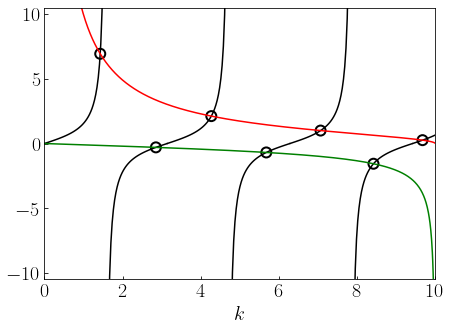

In [102]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

v0 = 100
N  = np.ceil(np.sqrt(v0)).astype(int)
for i in range(0,N):
    k = np.linspace(1.001*i*np.pi/2,0.999*(i+1)*np.pi/2)
    ax.plot(k,np.tan(k),'k')

k = np.linspace(1e-3,0.999*np.sqrt(v0),1000)
ax.plot(k,np.sqrt(v0/k**2-1),'r')
ax.plot(k,-1/np.sqrt(v0/k**2-1),'g')

ax.set_xlim(0,np.sqrt(v0))
ax.set_ylim(-10.5,10.5)
ax.tick_params(axis='both',which='major',direction='in',labelsize=20)
ax.set_xlabel(r'$k$',size=20)

E_ = get_finite_box_E(v0)
ax.scatter(E_**2,np.tan(E_**2),color='None',marker='o',edgecolor='k',s=100,lw=2)

plt.show()

### numerical stuff

-- to do: comparison with analytic solutions (transcendental equation for even/odd solutions, how many solutions exist)

In [103]:
def V(t,V0=1):
    temp = -V0*(np.abs(t) < 1).astype(float) + V0
    return temp

In [109]:
V0 = 10
x,E,psi = solve_SE(-10,10,100,lambda t: V(t,V0=V0))
h  = x[1] - x[0]
psi = psi/np.sqrt(h)

E[:10]

array([ 0.77653766,  3.02944479,  6.49360271, 10.02431531, 10.06106184,
       10.13265386, 10.24345277, 10.34638287, 10.54487815, 10.66934952])

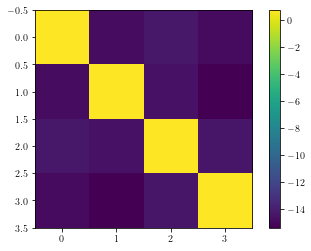

In [110]:
img = plt.imshow(np.log10(np.abs(psi[:4]@psi[:4].T)),cmap='viridis')
plt.colorbar(img)
plt.show()

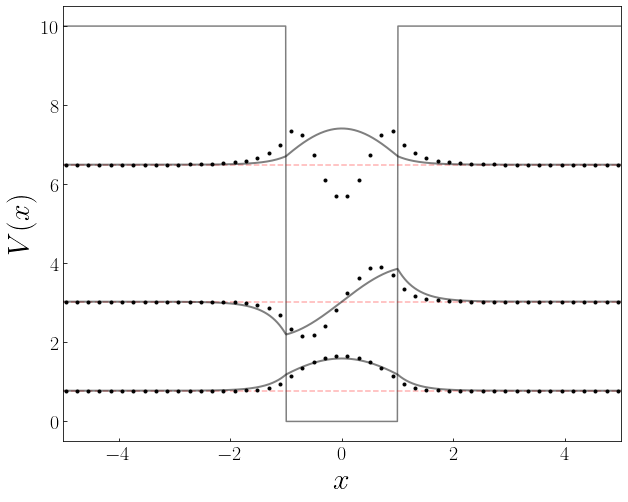

In [111]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,8*nrows))

x_ = np.linspace(-5,5,1000)
ax.plot(x_,V(x_,V0=V0),color='k',alpha=0.5)

E_,psi_ = get_finite_well_psi(x_,V0)

for i in range(len(E[E<V0])):
    ax.axhline(E[i],color='r',ls='--',alpha=0.3)
    ax.plot(x,psi[i] + E[i],'k.')
    ax.plot(x_,psi_[i]+E[i],'k-',lw=2,alpha=0.5)

ax.set_xlim(-5,5)
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$V(x)$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')

plt.show()

# Harmonic oscillator

In [ ]:
def V(t,m=1,w=1):
    return 0.5*m*w**2*t**2

In [ ]:
x,E,psi = solve_SE(-5,5,1000,V)

In [ ]:
E[:10]

In [ ]:
img = plt.imshow(np.log10(np.abs(psi@psi.T)),cmap='inferno')
plt.colorbar(img)

In [ ]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,8*nrows))

x_ = np.linspace(-5,5,1000)
ax.plot(x_,V(x_),color='k',alpha=0.5)


for i in range(12):
    ax.axhline(E[i],color='r',ls='--',alpha=0.3)
    ax.plot(x,5*psi[i] + E[i],'k-')

# ax.axhline(E[1],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[1] + E[1])

# ax.axhline(E[2],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[2] + E[2])

# ax.axhline(E[3],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[3] + E[3])

# ax.axhline(E[3],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[3] + E[4])

ax.set_xlim(-5,5)
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$V(x)$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')

plt.show()

In [ ]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

ax.plot(x,psi[0])
ax.plot(x,psi[1])
ax.plot(x,psi[2])
# ax.plot(x,psi[3])
# ax.plot(x,psi[4])

plt.show()

# Morse Potential

In [ ]:
def V(t,D=20,x0=1.5,a=0.5):
    return D*(1-np.exp(-a*(t-x0)))**2

In [ ]:
x,E,psi = solve_SE(0,3,100,V)

In [ ]:
E[:10]

In [ ]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,8*nrows))

x_ = np.linspace(0,3,1000)
ax.plot(x_,V(x_),color='k',alpha=0.5)


for i in range(4):
    ax.axhline(E[i],color='r',ls='--',alpha=0.3)
    ax.plot(x,5*psi[i] + E[i])

# ax.axhline(E[1],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[1] + E[1])

# ax.axhline(E[2],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[2] + E[2])

# ax.axhline(E[3],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[3] + E[3])

# ax.axhline(E[3],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[3] + E[4])

ax.set_xlim(0,3)
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$V(x)$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')

plt.show()

In [ ]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

ax.plot(x,psi[0])
ax.plot(x,psi[1])
ax.plot(x,psi[2])
# ax.plot(x,psi[3])
# ax.plot(x,psi[4])

plt.show()